In [1]:
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree

import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Patch
import os
from shutil import copy
import seaborn as sns

import datetime
from dateutil.relativedelta import relativedelta
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle
import imageio
from itertools import compress

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams.update({'figure.max_open_warning': 0})

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
          'legend.title_fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
#‘xx-small’, ‘x-small’, ‘small’, ‘medium’, ‘large’, ‘x-large’, ‘xx-large’
pylab.rcParams.update(params)
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
# from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
from statsmodels.tsa.api import VAR

from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn import tree

import re

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
#read data
#delta - 14 days SW-14 days FW
#median tempr - median temperature since first feeding until shipout
df=pd.read_csv('smolt_data_for_visuals.csv',sep=';')
df.transfer_date = pd.to_datetime(df.transfer_date,format='%d.%m.%Y')
print("Min Date:", df.transfer_date.min().strftime("%Y-%m-%d"),
      "\nMax Date:", df.transfer_date.max().strftime("%Y-%m-%d"))
df['delta_FW_minus_SW']=-df['delta']
season_dic2 = {1: 'Dec-Feb',2: 'Mar-May',3: 'Jun-Aug',4: 'Sep-Nov'}
df['transfer_season2']=(df['transfer_date'].dt.month%12 // 3 + 1).apply(lambda x: season_dic2[x])
reverse_season_dic = {v: k for k, v in season_dic2.items()}

# #tmp
# df=df[df['delta_FW_minus_SW']<6]

step=0.5
bins_tuple=tuple(i*step for i in range(int(df['median_tempr'].min()/step), int(df['median_tempr'].max()/step)+1))
df['median_tempr_cat0.5'] = pd.cut(df['median_tempr'], bins=bins_tuple)
bins_tuple=tuple(i*step for i in range(int(df['delta_FW_minus_SW'].min()/step), int(df['delta_FW_minus_SW'].max()/step)+1))
df['delta_FW_minus_SW_cat0.5'] = pd.cut(df['delta_FW_minus_SW'], bins=bins_tuple)

step=0.25
bins_tuple=tuple(i*step for i in range(int(df['median_tempr'].min()/step), int(df['median_tempr'].max()/step)+1))
df['median_tempr_cat0.25'] = pd.cut(df['median_tempr'], bins=bins_tuple)
bins_tuple=tuple(i*step for i in range(int(df['delta_FW_minus_SW'].min()/step), int(df['delta_FW_minus_SW'].max()/step)+1))
df['delta_FW_minus_SW_cat0.25'] = pd.cut(df['delta_FW_minus_SW'], bins=bins_tuple)
df['degree_days']=df['sum_of_temp']


Min Date: 2018-04-09 
Max Date: 2022-09-22


In [3]:
df.columns

Index(['locus_id', 'fish_group_id', 'transfer_year', 'transfer_month',
       'transfer_month_year', 'transfer_season', 'total_count',
       'total_mortality_perc_90', 'transport_mortality_perc_90',
       'nontransport_mortality_perc_90', 'from_date', 'from_site_name',
       'from_site_id', 'from_locus_id', 'from_locus_population_id',
       'from_fish_group_id', 'from_fish_group_name', 'from_generation',
       'from_year_class', 'from_count_stocking', 'from_avg_weight', 'to_date',
       'type_id', 'to_site_name', 'to_site_id', 'to_locus_id',
       'to_locus_population_id', 'to_fish_group_id', 'to_fish_group_name',
       'to_generation', 'to_year_class', 'to_count_stocking', 'to_avg_weight',
       'transfer_date', 'from_fish_group_count', 'days_btw_to_from',
       'days_btw_to_transfer', 'vac_fish_count', 'vac_weight',
       'days_btw_conf_event', '00000000000SRSv/Pha ', '000IPN+AAA+VVV+ISA/Pha',
       'IPN+SRS+VIB+ASA+ISA/FAV', 'IPN+SRS+VVV+AAA+ISA/Pha',
       'IPN+SRS+VVV

In [4]:
target = 'Proxy'

In [5]:
df_short=df[['locus_id','fish_group_id','transfer_year','transfer_season2','total_mortality_perc_90','from_year_class','to_avg_weight','strain','delta_FW_minus_SW','median_tempr','average_tempr','days_in_fresh_water','degree_days','Proxy']]#,'median_tempr_cat0.5','median_tempr_cat0.25','delta_FW_minus_SW_cat0.5','delta_FW_minus_SW_cat0.25']]

In [6]:
df_short.corr()

,locus_id,fish_group_id,transfer_year,total_mortality_perc_90,from_year_class,to_avg_weight,delta_FW_minus_SW,median_tempr,average_tempr,days_in_fresh_water,degree_days,Proxy
locus_id,1.000000,0.464087,0.491465,-0.015342,0.440479,0.198524,0.074168,0.080273,-0.086806,0.050608,0.123175,0.201682
fish_group_id,0.464087,1.000000,0.879866,-0.046480,0.880120,0.288445,0.075969,-0.210548,-0.500324,-0.070008,0.095537,0.295497
transfer_year,0.491465,0.879866,1.000000,0.070206,0.976692,0.501714,0.091392,-0.025433,-0.363063,-0.079015,0.307045,0.503091
total_mortality_perc_90,-0.015342,-0.046480,0.070206,1.000000,0.077096,0.114261,0.218032,0.148766,0.111392,-0.004803,0.163657,0.056241
from_year_class,0.440479,0.880120,0.976692,0.077096,1.000000,0.438455,0.104335,-0.014083,-0.363854,-0.157711,0.256179,0.438763
to_avg_weight,0.198524,0.288445,0.501714,0.114261,0.438455,1.000000,-0.046683,-0.000377,-0.187754,0.264441,0.600164,0.998210
delta_FW_minus_SW,0.074168,0.075969,0.091392,0.218032,0.104335,-0.046683,1.000000,0.220680,0.280964,0.001462,0.160692,-0.059322
median_tempr,0.080273,-0.210548,-0.025433,0.148766,-0.014083,-0.000377,0.220680,1.000000,0.716927,-0.052671,0.113994,-0.008283
average_tempr,-0.086806,-0.500324,-0.363063,0.111392,-0.363854,-0.187754,0.280964,0.716927,1.000000,-0.088437,0.009014,-0.195354
days_in_fresh_water,0.050608,-0.070008,-0.079015,-0.004803,-0.157711,0.264441,0.001462,-0.052671,-0.088437,1.000000,0.524480,0.266721


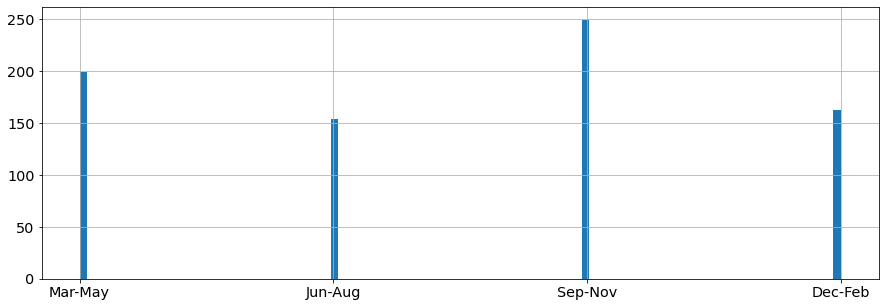

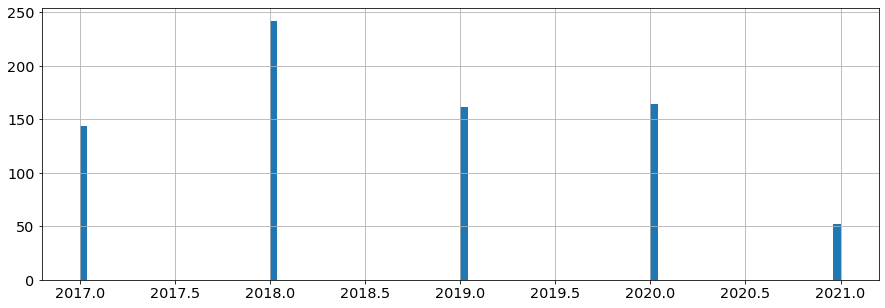

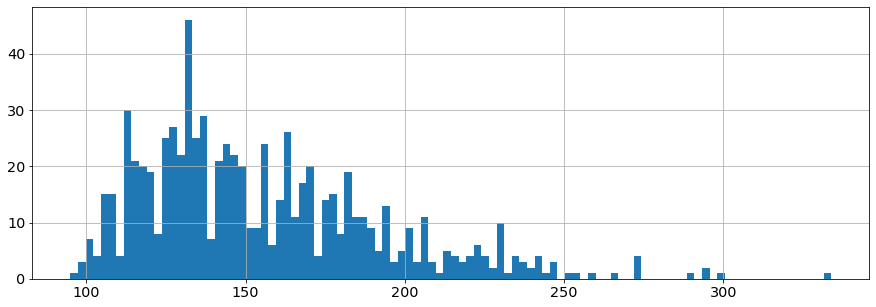

In [7]:
#hists on stocking conditions
plt.figure()
df_short['transfer_season2'].hist(bins=100)
plt.figure()
df_short['from_year_class'].hist(bins=100)
plt.figure()
df_short['to_avg_weight'].hist(bins=100)

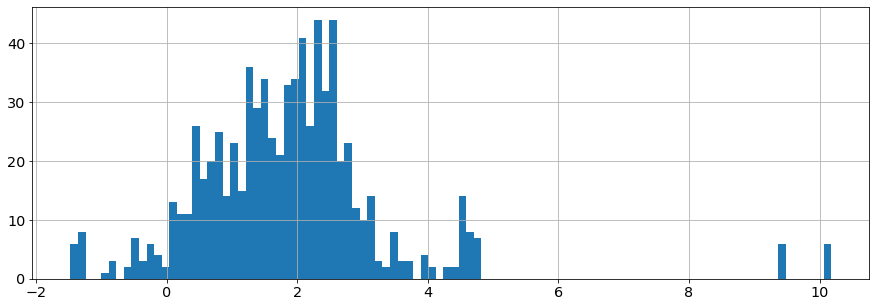

In [8]:
df_short['delta_FW_minus_SW'].hist(bins=100)


In [9]:
#filters
print(len(df_short))
df_short_filtered=df_short[df_short.to_avg_weight<250]
print(len(df_short_filtered))
# df_short_filtered=df_short_filtered[df_short_filtered.from_year_class<=2020]
# df_short_filtered=df_short_filtered[df_short_filtered.delta_FW_minus_SW<6]
# print(len(df_short_filtered))

764
751


In [10]:
# arr_for_chart = df_short_filtered
# # arr_for_chart['total_mortality_perc_90_perc']=arr_for_chart[target]*100
# y_axis_factor='median_tempr'
# x_axis_factor='transfer_season2'
# f, axs = plt.subplots(1,1,
#                       figsize=(20,10),
#                       sharex=True,
#                      )
# box_plot=sns.boxplot(data=arr_for_chart,x=x_axis_factor,y=y_axis_factor,hue='from_year_class',showfliers=False)

# # medians = arr_for_chart.groupby(['transfer_season2'])['total_mortality_perc_90_perc'].mean()
# # vertical_offset = arr_for_chart['total_mortality_perc_90_perc'].mean() * 0.00 # offset from median for display
# # for xtick in box_plot.get_xticks():
# # #     print(xtick)
# #     box_plot.text(xtick,medians[xtick+1] + vertical_offset,round(medians[xtick+1],1), 
# #             horizontalalignment='center',size='medium',color='black',weight='semibold')

# tmp_xlabels=[]
# for i in range(len(axs.get_xticklabels())):
#     ttext=axs.get_xticklabels()[i].get_text()
# #     tmp_xlabels.append(ttext+'('+str(arr_for_chart[x_axis_factor].value_counts()[int(ttext)])+')')
#     tmp_xlabels.append(ttext+'('+str(arr_for_chart[x_axis_factor].value_counts()[ttext])+')')

# axs.set_xticklabels(tmp_xlabels)
# plt.xlabel(x_axis_factor)
# plt.ylabel(y_axis_factor)
# # plt.savefig('Visualisation\\'+y_axis_factor+' vs. '+ x_axis_factor+'.jpg')

In [11]:
# arr_for_chart = df_short_filtered
# # arr_for_chart['total_mortality_perc_90_perc']=arr_for_chart[target]*100
# y_axis_factor='delta_FW_minus_SW'
# x_axis_factor='transfer_season2'
# f, axs = plt.subplots(1,1,
#                       figsize=(20,10),
#                       sharex=True,
#                      )
# box_plot=sns.boxplot(data=arr_for_chart,x=x_axis_factor,y=y_axis_factor,hue='from_year_class',showfliers=False)

# # medians = arr_for_chart.groupby(['transfer_season2'])['total_mortality_perc_90_perc'].mean()
# # vertical_offset = arr_for_chart['total_mortality_perc_90_perc'].mean() * 0.00 # offset from median for display
# # for xtick in box_plot.get_xticks():
# # #     print(xtick)
# #     box_plot.text(xtick,medians[xtick+1] + vertical_offset,round(medians[xtick+1],1), 
# #             horizontalalignment='center',size='medium',color='black',weight='semibold')

# tmp_xlabels=[]
# for i in range(len(axs.get_xticklabels())):
#     ttext=axs.get_xticklabels()[i].get_text()
# #     tmp_xlabels.append(ttext+'('+str(arr_for_chart[x_axis_factor].value_counts()[int(ttext)])+')')
#     tmp_xlabels.append(ttext+'('+str(arr_for_chart[x_axis_factor].value_counts()[ttext])+')')

# axs.set_xticklabels(tmp_xlabels)
# plt.xlabel(x_axis_factor)
# plt.ylabel(y_axis_factor)
# # plt.savefig('Visualisation\\'+y_axis_factor+' vs. '+ x_axis_factor+'.jpg')

<Figure size 1080x360 with 0 Axes>

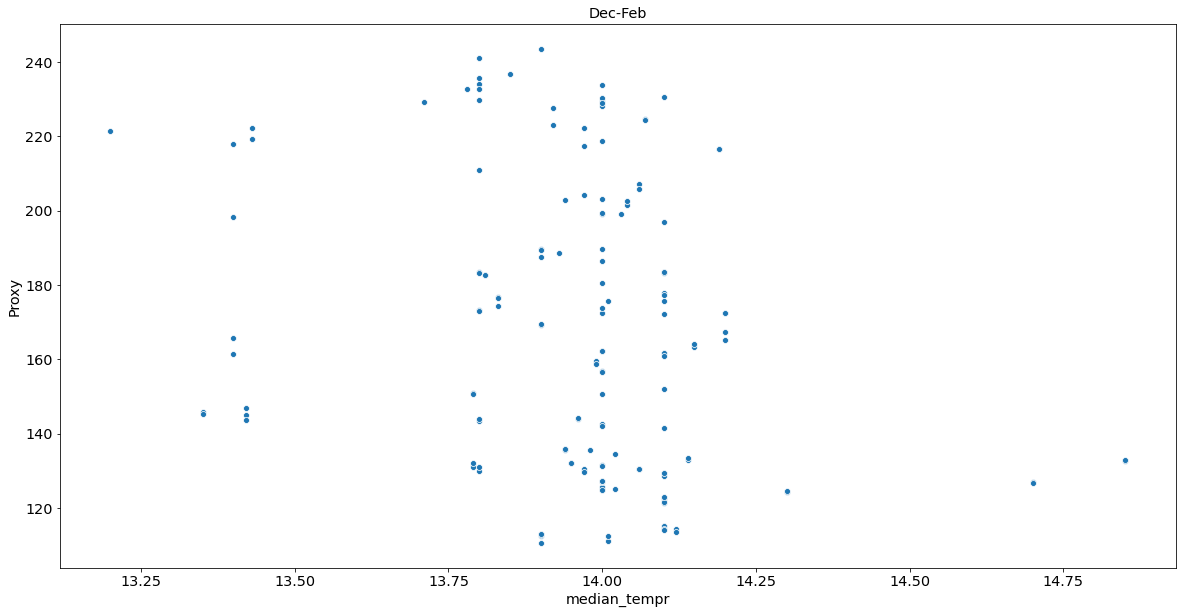

<Figure size 1080x360 with 0 Axes>

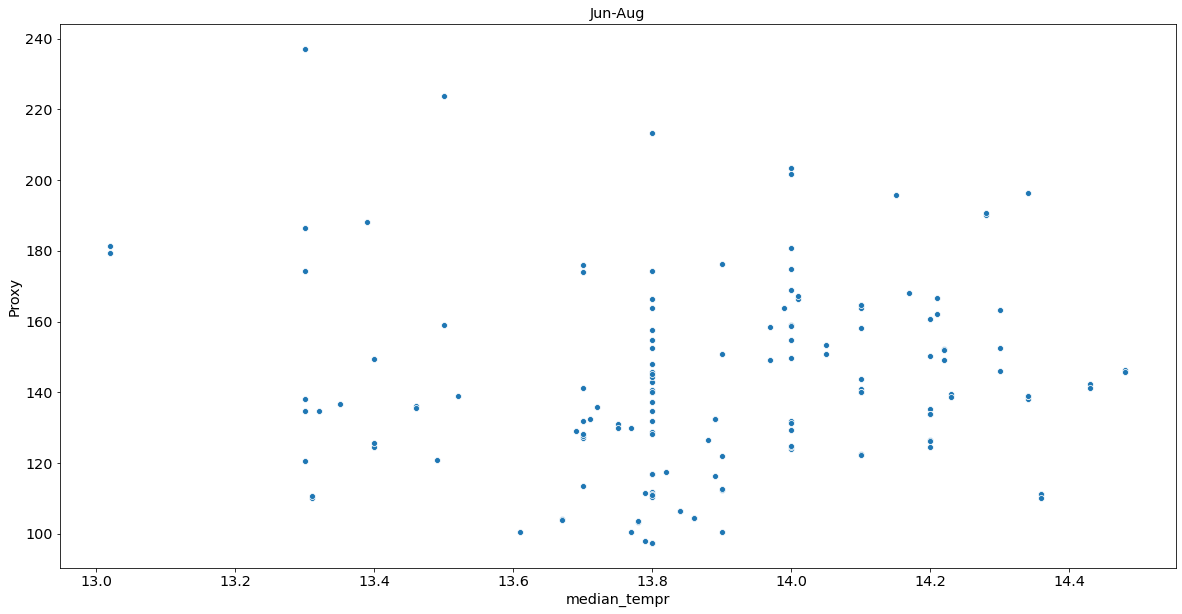

<Figure size 1080x360 with 0 Axes>

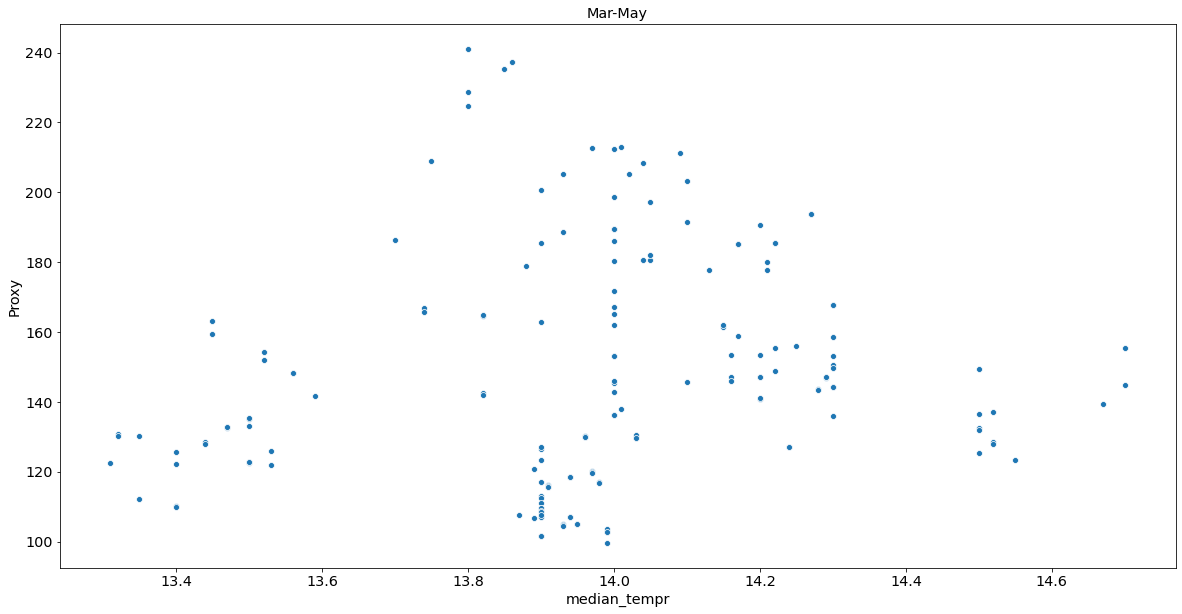

<Figure size 1080x360 with 0 Axes>

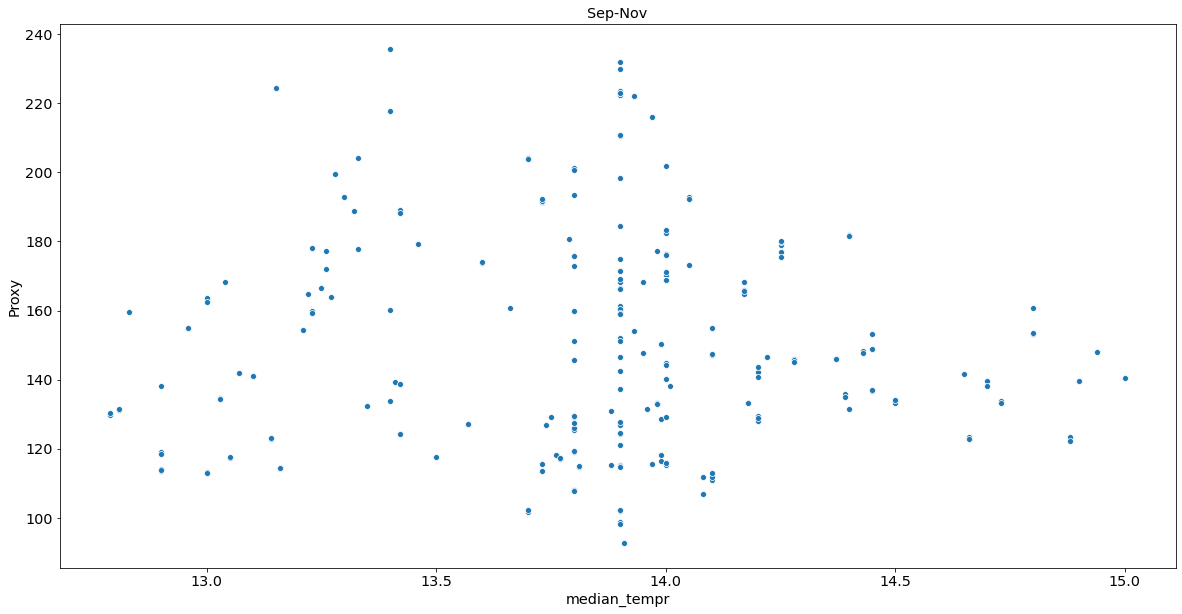

In [12]:
for season,curr_df in df_short_filtered.groupby('transfer_season2'):
    plt.figure()
    arr_for_chart = curr_df
    # arr_for_chart['total_mortality_perc_90_perc']=arr_for_chart[target]*100
    y_axis_factor=target
    x_axis_factor='median_tempr'
    f, axs = plt.subplots(1,1,
                          figsize=(20,10),
                          sharex=True,
                         )
    scatter_plot=sns.scatterplot(data=arr_for_chart,x=x_axis_factor,y=y_axis_factor)
    plt.xlabel(x_axis_factor)
    plt.ylabel(y_axis_factor)
    plt.title(season)
#     plt.savefig('Visualisation\\'+y_axis_factor+' vs. '+ x_axis_factor+'.jpg')

Text(0, 0.5, 'Proxy')

<Figure size 1080x360 with 0 Axes>

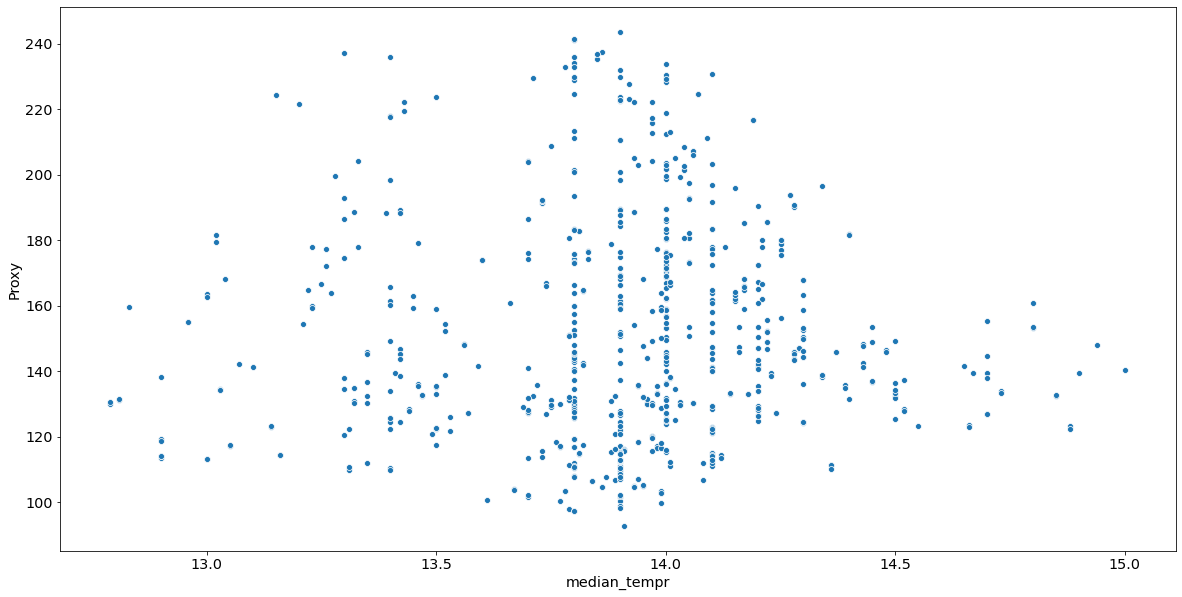

In [13]:
plt.figure()
arr_for_chart = df_short_filtered
# arr_for_chart['total_mortality_perc_90_perc']=arr_for_chart[target]*100
y_axis_factor=target
x_axis_factor='median_tempr'
f, axs = plt.subplots(1,1,
                      figsize=(20,10),
                      sharex=True,
                     )
scatter_plot=sns.scatterplot(data=arr_for_chart,x=x_axis_factor,y=y_axis_factor)
plt.xlabel(x_axis_factor)
plt.ylabel(y_axis_factor)
# plt.title(season)
# plt.savefig('Visualisation\\'+y_axis_factor+' vs. '+ x_axis_factor+'_scatter.jpg')

Text(0, 0.5, 'total_mortality_perc_90_perc')

<Figure size 1080x360 with 0 Axes>

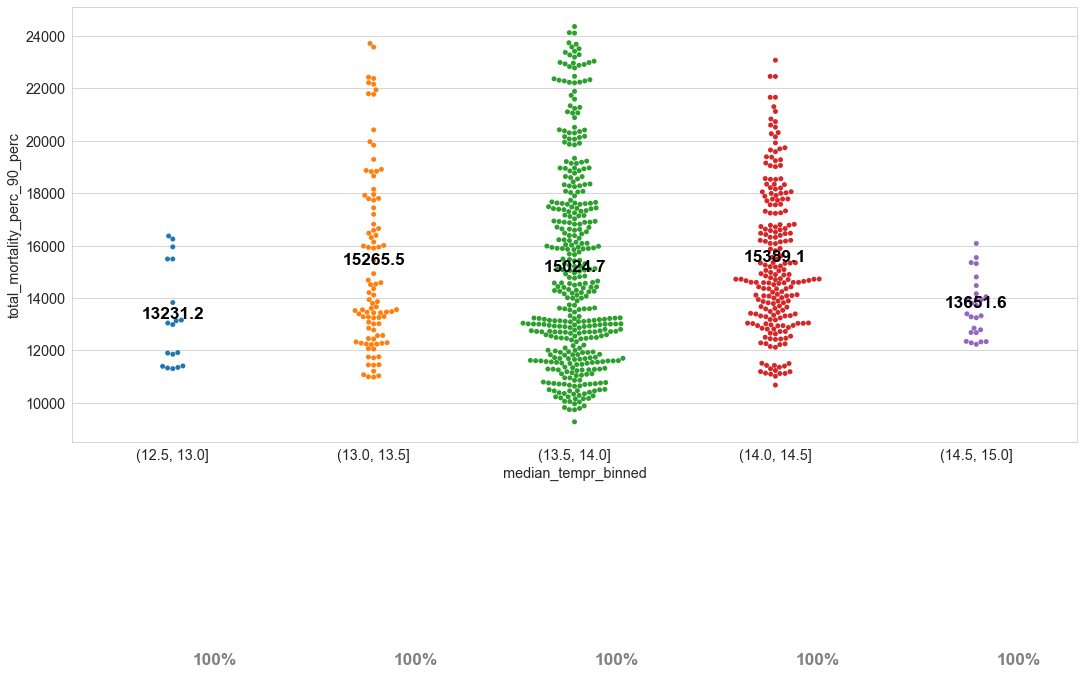

In [14]:
sns.set_style("whitegrid")

step=.5
bins_tuple=tuple(i*step for i in range(int(df['median_tempr'].min()/step), int(df['median_tempr'].max()/step)+1))

plt.figure()
arr_for_chart = df_short_filtered
arr_for_chart['total_mortality_perc_90_perc']=arr_for_chart[target]*100
arr_for_chart['median_tempr_binned']=pd.cut(df_short_filtered['median_tempr'], bins=bins_tuple)

y_axis_factor='total_mortality_perc_90_perc'
x_axis_factor='median_tempr_binned'
f, axs = plt.subplots(1,1,
                      figsize=(18,8),
                      sharex=True,
                     )
# box_plot=sns.boxplot(data=arr_for_chart,x=x_axis_factor,y=y_axis_factor,showfliers=True)
box_plot=sns.swarmplot(data=arr_for_chart,x=x_axis_factor,y=y_axis_factor)


medians = arr_for_chart.groupby(x_axis_factor)[y_axis_factor].mean()
vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
#     print(xtick)
    box_plot.text(xtick,medians.iloc[xtick] + vertical_offset,round(medians.iloc[xtick],1), 
            horizontalalignment='center',size='xx-large',color='black',weight='semibold')

    
counts_above_2=arr_for_chart[arr_for_chart[target]>0.02].groupby(x_axis_factor)[y_axis_factor].count()/arr_for_chart.groupby(x_axis_factor)[y_axis_factor].count()
vertical_offset = 3
for xtick in box_plot.get_xticks():
#     print(xtick)
    box_plot.text(xtick+0.1,counts_above_2.iloc[xtick] + vertical_offset,"{:.0%}".format(counts_above_2.iloc[xtick]), 
            horizontalalignment='left',size='xx-large',color='grey',weight='semibold')

#     tmp_xlabels=[]
#     for i in range(len(axs.get_xticklabels())):
#         ttext=axs.get_xticklabels()[i].get_text()
# #         tmp_xlabels.append(ttext+'('+str(arr_for_chart[x_axis_factor].value_counts()[int(ttext)])+')')
#         tmp_xlabels.append(ttext+'('+str(arr_for_chart[x_axis_factor].value_counts()[ttext])+')')
#     axs.set_xticklabels(tmp_xlabels)

# plt.xlabel(x_axis_factor)
plt.ylabel(y_axis_factor)
# plt.savefig('Visualisation\\'+y_axis_factor+' vs. '+ x_axis_factor+'.jpg')


# proxy metric graph


FileNotFoundError: [Errno 2] No such file or directory: 'Visualisation\\Proxy vs. degree_days_binned.jpg'

<Figure size 1080x360 with 0 Axes>

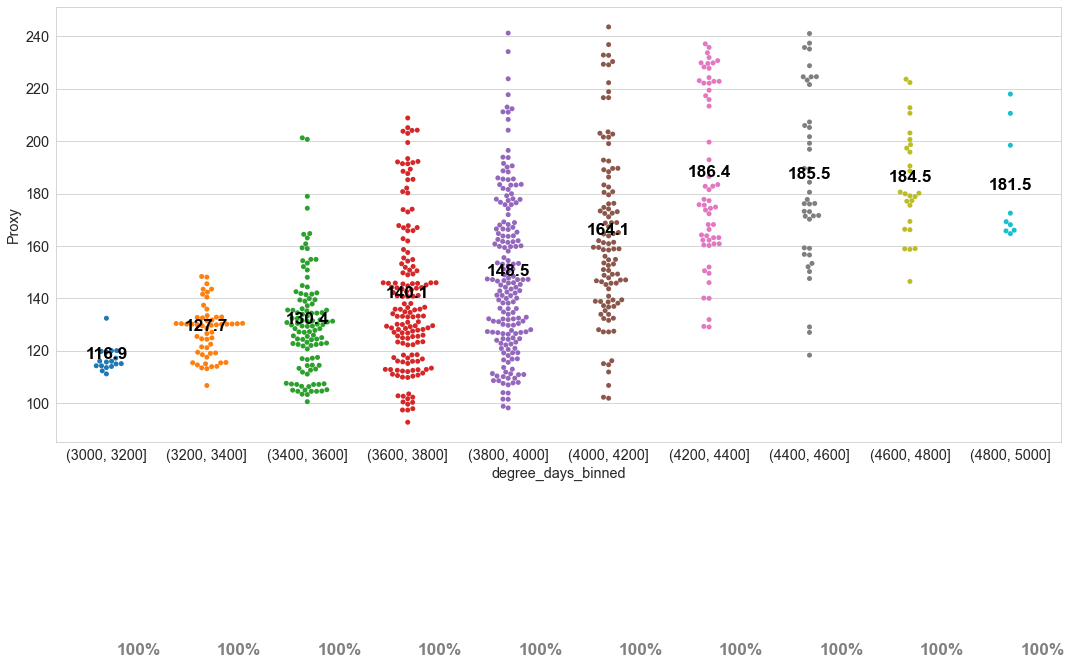

In [20]:
sns.set_style("whitegrid")

step=200
bins_tuple=tuple(i*step for i in range(int(df['degree_days'].min()/step), int(df['degree_days'].max()/step)+1))

plt.figure()
arr_for_chart = df_short_filtered
arr_for_chart['Proxy']=arr_for_chart[target]/10000
arr_for_chart['degree_days_binned']=pd.cut(df_short_filtered['degree_days'], bins=bins_tuple)

y_axis_factor='Proxy'
x_axis_factor='degree_days_binned'
f, axs = plt.subplots(1,1,
                      figsize=(18,8),
                      sharex=True,
                     )
# box_plot=sns.boxplot(data=arr_for_chart,x=x_axis_factor,y=y_axis_factor,showfliers=True)
box_plot=sns.swarmplot(data=arr_for_chart,x=x_axis_factor,y=y_axis_factor)


medians = arr_for_chart.groupby(x_axis_factor)[y_axis_factor].mean()
vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
#     print(xtick)
    box_plot.text(xtick,medians.iloc[xtick] + vertical_offset,round(medians.iloc[xtick],1), 
            horizontalalignment='center',size='xx-large',color='black',weight='semibold')

    
counts_above_2=arr_for_chart[arr_for_chart[target]>0.02].groupby(x_axis_factor)[y_axis_factor].count()/arr_for_chart.groupby(x_axis_factor)[y_axis_factor].count()
vertical_offset = 3
for xtick in box_plot.get_xticks():
#     print(xtick)
    box_plot.text(xtick+0.1,counts_above_2.iloc[xtick] + vertical_offset,"{:.0%}".format(counts_above_2.iloc[xtick]), 
            horizontalalignment='left',size='xx-large',color='grey',weight='semibold')

#     tmp_xlabels=[]
#     for i in range(len(axs.get_xticklabels())):
#         ttext=axs.get_xticklabels()[i].get_text()
# #         tmp_xlabels.append(ttext+'('+str(arr_for_chart[x_axis_factor].value_counts()[int(ttext)])+')')
#         tmp_xlabels.append(ttext+'('+str(arr_for_chart[x_axis_factor].value_counts()[ttext])+')')
#     axs.set_xticklabels(tmp_xlabels)

# plt.xlabel(x_axis_factor)
plt.ylabel(y_axis_factor)
plt.savefig('Visualisation\\'+y_axis_factor+' vs. '+ x_axis_factor+'.jpg')

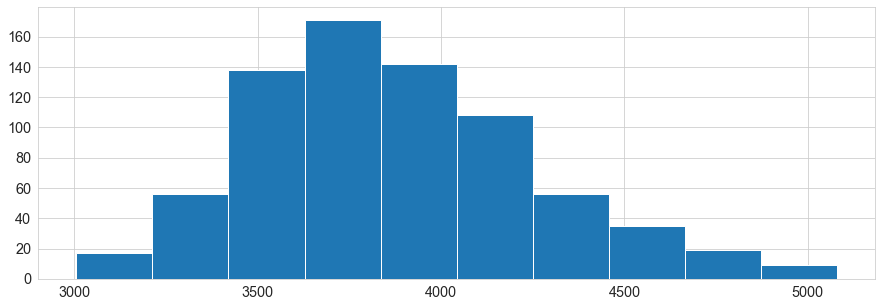

In [16]:
df_short_filtered['degree_days'].hist()

In [ ]:
df_short_filtered['days_in_fresh_water'].hist()

In [28]:
df['average_tempr'].describe()

count    764.000000
mean      13.673338
std        0.456998
min       11.470000
25%       13.340000
50%       13.710000
75%       14.032500
max       14.540000
Name: average_tempr, dtype: float64

Text(0, 0.5, 'total_mortality_perc_90_perc')

<Figure size 1080x360 with 0 Axes>

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


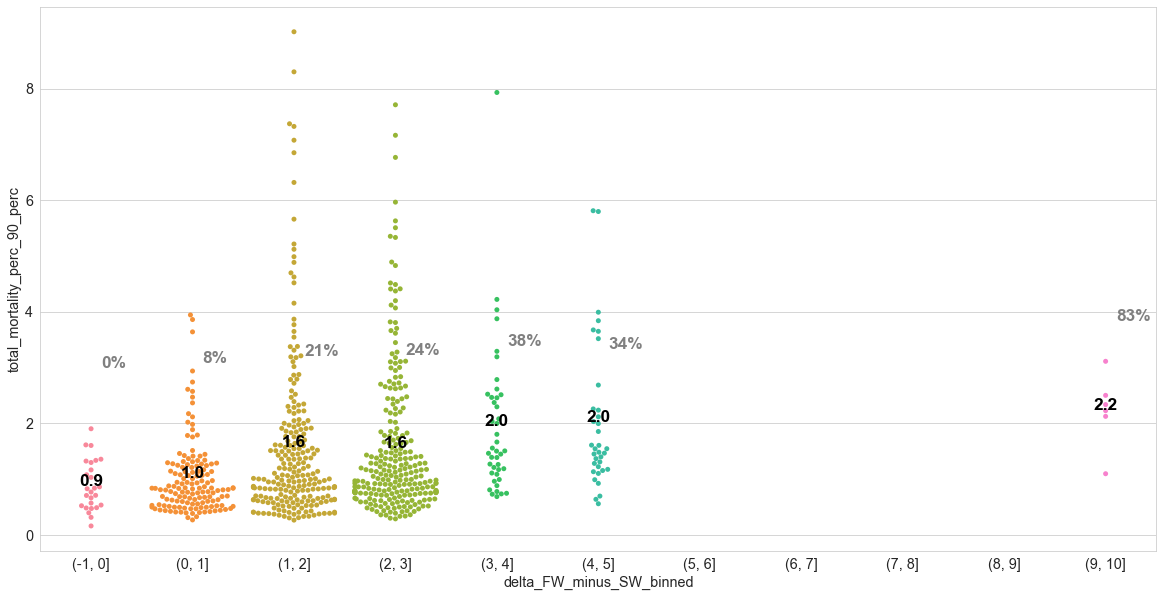

In [29]:
sns.set_style("whitegrid")

step=1
bins_tuple=tuple(i*step for i in range(int(df['delta_FW_minus_SW'].min()/step), int(df['delta_FW_minus_SW'].max()/step)+1))

plt.figure()
arr_for_chart = df_short_filtered
arr_for_chart['total_mortality_perc_90_perc']=arr_for_chart[target]*100
arr_for_chart['delta_FW_minus_SW_binned']=pd.cut(df_short_filtered['delta_FW_minus_SW'], bins=bins_tuple)

y_axis_factor='total_mortality_perc_90_perc'
x_axis_factor='delta_FW_minus_SW_binned'
f, axs = plt.subplots(1,1,
                      figsize=(20,10),
                      sharex=True,
                     )
box_plot=sns.swarmplot(data=arr_for_chart,x=x_axis_factor,y=y_axis_factor)

medians = arr_for_chart.groupby(x_axis_factor)[y_axis_factor].mean()
vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
#     print(xtick)
    box_plot.text(xtick,medians.iloc[xtick] + vertical_offset,round(medians.iloc[xtick],1), 
            horizontalalignment='center',size='xx-large',color='black',weight='semibold')
    
counts_above_2=arr_for_chart[arr_for_chart[target]>0.02].groupby(x_axis_factor)[y_axis_factor].count()/arr_for_chart.groupby(x_axis_factor)[y_axis_factor].count()
vertical_offset = 3
for xtick in box_plot.get_xticks():
#     print(xtick)
    box_plot.text(xtick+0.1,counts_above_2.iloc[xtick] + vertical_offset,"{:.0%}".format(counts_above_2.iloc[xtick]), 
            horizontalalignment='left',size='xx-large',color='grey',weight='semibold')

#     tmp_xlabels=[]
#     for i in range(len(axs.get_xticklabels())):
#         ttext=axs.get_xticklabels()[i].get_text()
# #         tmp_xlabels.append(ttext+'('+str(arr_for_chart[x_axis_factor].value_counts()[int(ttext)])+')')
#         tmp_xlabels.append(ttext+'('+str(arr_for_chart[x_axis_factor].value_counts()[ttext])+')')
#     axs.set_xticklabels(tmp_xlabels)

plt.xlabel(x_axis_factor)
plt.ylabel(y_axis_factor)
# plt.savefig('Visualisation\\'+y_axis_factor+' vs. '+ x_axis_factor+'.jpg')

<Figure size 1080x360 with 0 Axes>

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

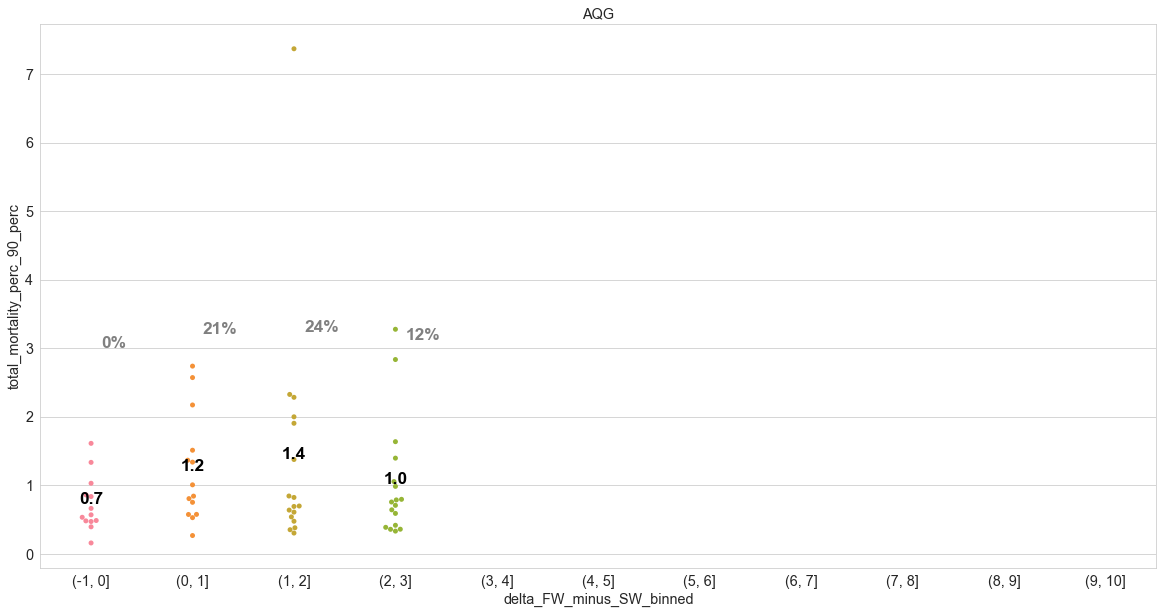

<Figure size 1080x360 with 0 Axes>

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


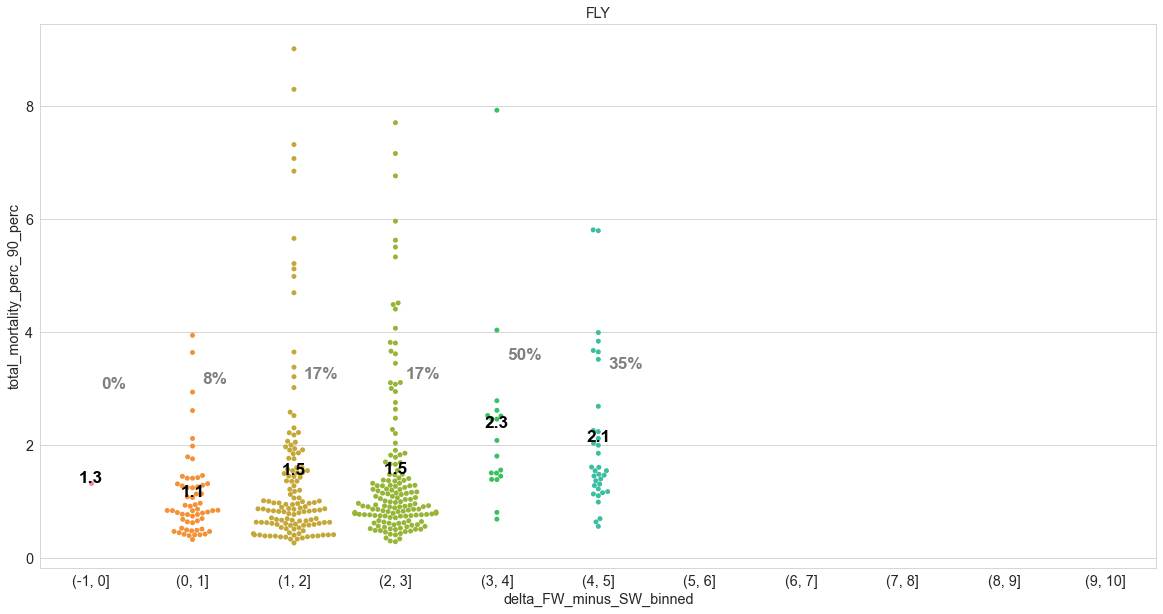

<Figure size 1080x360 with 0 Axes>

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


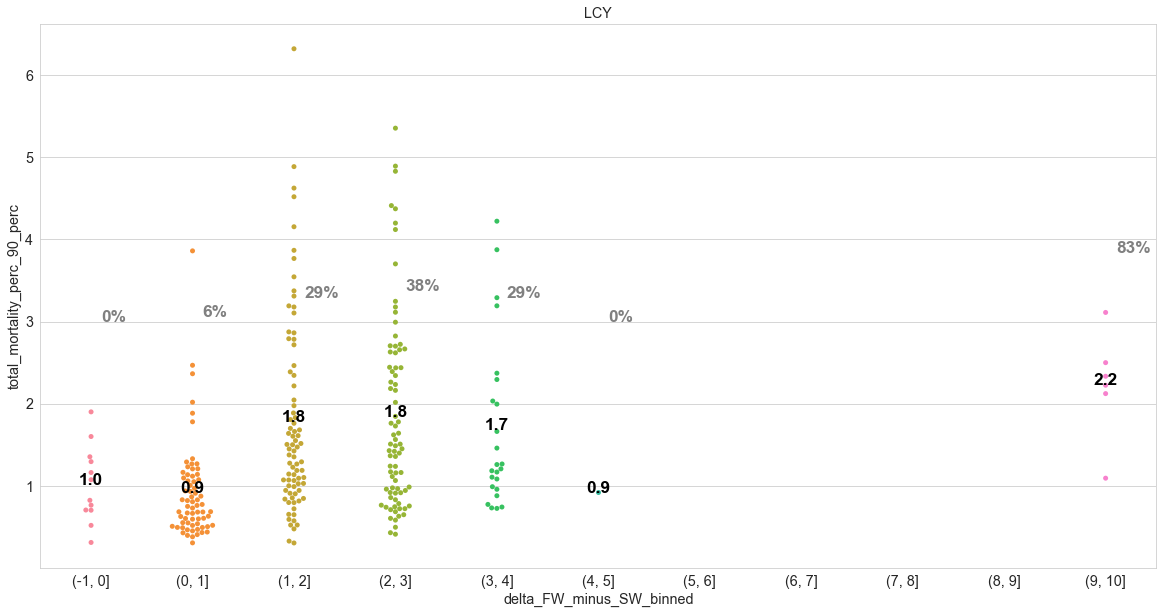

In [30]:
sns.set_style("whitegrid")

step=1
bins_tuple=tuple(i*step for i in range(int(df['delta_FW_minus_SW'].min()/step), int(df['delta_FW_minus_SW'].max()/step)+1))

arr_for_chart = df_short_filtered
arr_for_chart['total_mortality_perc_90_perc']=arr_for_chart[target]*100
arr_for_chart['delta_FW_minus_SW_binned']=pd.cut(df_short_filtered['delta_FW_minus_SW'], bins=bins_tuple)

y_axis_factor='total_mortality_perc_90_perc'
x_axis_factor='delta_FW_minus_SW_binned'

for strain,curr_df in df_short_filtered.groupby('strain'):
    arr_for_chart=curr_df
    plt.figure()
    f, axs = plt.subplots(1,1,
                          figsize=(20,10),
                          sharex=True,
                         )
    box_plot=sns.swarmplot(data=arr_for_chart,x=x_axis_factor,y=y_axis_factor)

    medians = arr_for_chart.groupby(x_axis_factor)[y_axis_factor].mean()
    vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
    for xtick in box_plot.get_xticks():
    #     print(xtick)
        box_plot.text(xtick,medians.iloc[xtick] + vertical_offset,round(medians.iloc[xtick],1), 
                horizontalalignment='center',size='xx-large',color='black',weight='semibold')

    counts_above_2=arr_for_chart[arr_for_chart[target]>0.02].groupby(x_axis_factor)[y_axis_factor].count()/arr_for_chart.groupby(x_axis_factor)[y_axis_factor].count()
    vertical_offset = 3
    for xtick in box_plot.get_xticks():
    #     print(xtick)
        box_plot.text(xtick+0.1,counts_above_2.iloc[xtick] + vertical_offset,"{:.0%}".format(counts_above_2.iloc[xtick]), 
                horizontalalignment='left',size='xx-large',color='grey',weight='semibold')

    #     tmp_xlabels=[]
    #     for i in range(len(axs.get_xticklabels())):
    #         ttext=axs.get_xticklabels()[i].get_text()
    # #         tmp_xlabels.append(ttext+'('+str(arr_for_chart[x_axis_factor].value_counts()[int(ttext)])+')')
    #         tmp_xlabels.append(ttext+'('+str(arr_for_chart[x_axis_factor].value_counts()[ttext])+')')
    #     axs.set_xticklabels(tmp_xlabels)

    plt.xlabel(x_axis_factor)
    plt.ylabel(y_axis_factor)
    plt.title(strain)
    # plt.savefig('Visualisation\\'+y_axis_factor+' vs. '+ x_axis_factor+'.jpg')

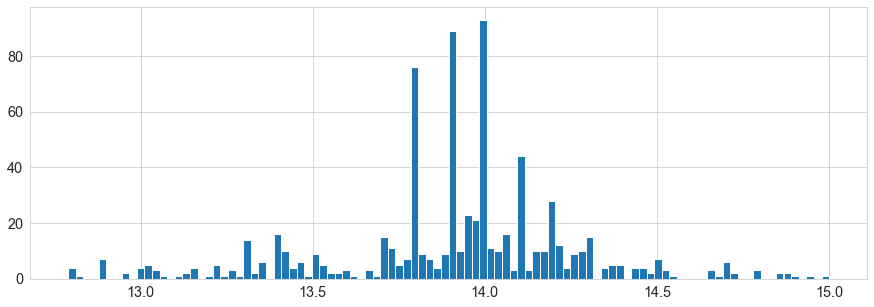

In [31]:
df_short_filtered['median_tempr'].hist(bins=100)

In [32]:
ttext

NameError: name 'ttext' is not defined

In [33]:
medians

delta_FW_minus_SW_binned
(-1, 0]    1.020840
(0, 1]     0.913044
(1, 2]     1.786899
(2, 3]     1.844466
(3, 4]     1.688253
(4, 5]     0.923551
(5, 6]          NaN
(6, 7]          NaN
(7, 8]          NaN
(8, 9]          NaN
(9, 10]    2.232504
Name: total_mortality_perc_90_perc, dtype: float64

In [35]:
sns.set_style("whitegrid")

step=100
bins_tuple=tuple(i*step for i in range(int(df['sum_of_temp'].min()/step), int(df['sum_of_temp'].max()/step)+1))

plt.figure()
arr_for_chart = df_short_filtered
arr_for_chart['total_mortality_perc_90_perc']=arr_for_chart[target]*100
arr_for_chart['SOT_binned']=pd.cut(df_short_filtered['sum_of_temp'], bins=bins_tuple)

y_axis_factor='total_mortality_perc_90_perc'
x_axis_factor='SOT_binned'
f, axs = plt.subplots(1,1,
                      figsize=(18,8),
                      sharex=True,
                     )
# box_plot=sns.boxplot(data=arr_for_chart,x=x_axis_factor,y=y_axis_factor,showfliers=True)
box_plot=sns.swarmplot(data=arr_for_chart,x=x_axis_factor,y=y_axis_factor)


medians = arr_for_chart.groupby(x_axis_factor)[y_axis_factor].mean()
vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
#     print(xtick)
    box_plot.text(xtick,medians.iloc[xtick] + vertical_offset,round(medians.iloc[xtick],1), 
            horizontalalignment='center',size='xx-large',color='black',weight='semibold')

    
counts_above_2=arr_for_chart[arr_for_chart[target]>0.02].groupby(x_axis_factor)[y_axis_factor].count()/arr_for_chart.groupby(x_axis_factor)[y_axis_factor].count()
vertical_offset = 3
for xtick in box_plot.get_xticks():
#     print(xtick)
    box_plot.text(xtick+0.1,counts_above_2.iloc[xtick] + vertical_offset,"{:.0%}".format(counts_above_2.iloc[xtick]), 
            horizontalalignment='left',size='xx-large',color='grey',weight='semibold')

#     tmp_xlabels=[]
#     for i in range(len(axs.get_xticklabels())):
#         ttext=axs.get_xticklabels()[i].get_text()
# #         tmp_xlabels.append(ttext+'('+str(arr_for_chart[x_axis_factor].value_counts()[int(ttext)])+')')
#         tmp_xlabels.append(ttext+'('+str(arr_for_chart[x_axis_factor].value_counts()[ttext])+')')
#     axs.set_xticklabels(tmp_xlabels)

# plt.xlabel(x_axis_factor)
plt.ylabel(y_axis_factor)
plt.savefig('Visualisation\\'+y_axis_factor+' vs. '+ x_axis_factor+'.jpg')

KeyError: 'sum_of_temp'

<Figure size 1080x360 with 0 Axes>

ValueError: min() arg is an empty sequence

<Figure size 1080x360 with 0 Axes>

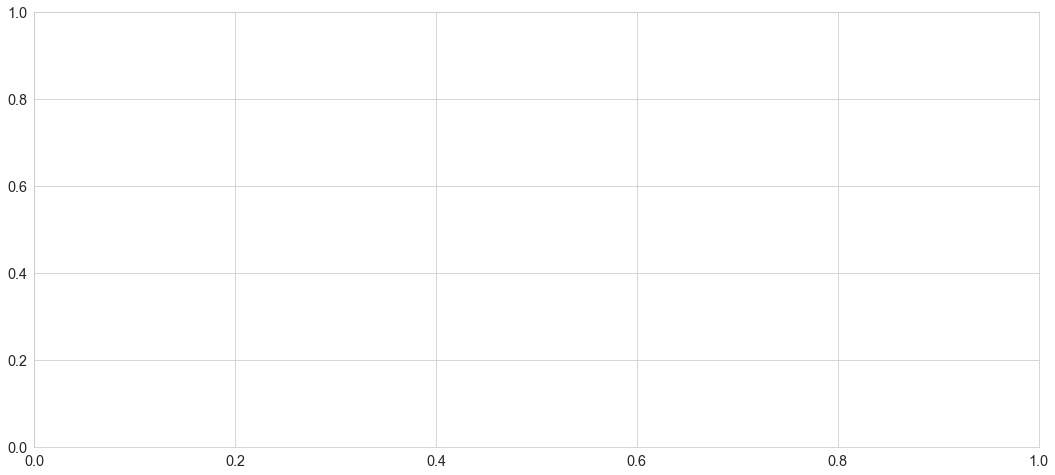

In [54]:
sns.set_style("whitegrid")

step=200
bins_tuple=tuple(i*step for i in range(int(df['SGR'].min()/step), int(df['SGR'].max()/step)+1))

plt.figure()
arr_for_chart = df_short_filtered
arr_for_chart['SGR']=arr_for_chart[target]*100
arr_for_chart['degree_days_binned']=pd.cut(df_short_filtered['degree_days'], bins=bins_tuple)

y_axis_factor='SGR'
x_axis_factor='degree_days_binned'
f, axs = plt.subplots(1,1,
                      figsize=(18,8),
                      sharex=True,
                     )
# box_plot=sns.boxplot(data=arr_for_chart,x=x_axis_factor,y=y_axis_factor,showfliers=True)
box_plot=sns.swarmplot(data=arr_for_chart,x=x_axis_factor,y=y_axis_factor)


medians = arr_for_chart.groupby(x_axis_factor)[y_axis_factor].mean()
vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
#     print(xtick)
    box_plot.text(xtick,medians.iloc[xtick] + vertical_offset,round(medians.iloc[xtick],1), 
            horizontalalignment='center',size='xx-large',color='black',weight='semibold')

    
counts_above_2=arr_for_chart[arr_for_chart[target]>0.02].groupby(x_axis_factor)[y_axis_factor].count()/arr_for_chart.groupby(x_axis_factor)[y_axis_factor].count()
vertical_offset = 3
for xtick in box_plot.get_xticks():
#     print(xtick)
    box_plot.text(xtick+0.1,counts_above_2.iloc[xtick] + vertical_offset,"{:.0%}".format(counts_above_2.iloc[xtick]), 
            horizontalalignment='left',size='xx-large',color='grey',weight='semibold')

#     tmp_xlabels=[]
#     for i in range(len(axs.get_xticklabels())):
#         ttext=axs.get_xticklabels()[i].get_text()
# #         tmp_xlabels.append(ttext+'('+str(arr_for_chart[x_axis_factor].value_counts()[int(ttext)])+')')
#         tmp_xlabels.append(ttext+'('+str(arr_for_chart[x_axis_factor].value_counts()[ttext])+')')
#     axs.set_xticklabels(tmp_xlabels)

# plt.xlabel(x_axis_factor)
plt.ylabel(y_axis_factor)
plt.savefig('Visualisation\\'+y_axis_factor+' vs. '+ x_axis_factor+'.jpg')